# WISDM 시계열 데이터 CNN 분류 과정

## 1. 환경 설정
- 데이터 경로, 랜덤 시드(seed), 하이퍼파라미터 설정  
  - `WINDOW_SIZE` (200), `STEP_SIZE` (100), `EPOCHS` (12) 등  
- GPU 사용 가능 여부 확인 후 `DEVICE` 설정  

## 2. 데이터 읽기 & 파싱
- `WISDM_ar_v1.1_raw.txt` 파일에서 한 줄씩 읽어 다음 항목 추출(user, activity, timestamp, x, y, z)

- 공백, 세미콜론 등 불필요한 문자 제거  
- 시간 순으로 정렬하여 **Pandas DataFrame** 생성  

## 3. 데이터 분할
- **사용자 기준(user-wise)** 으로 데이터 분리  
- Train: 70%, Validation: 10%, Test: 20%  
- 목적: 데이터 누수 방지 (같은 사용자가 train/test에 동시에 포함되지 않도록)  

## 4. 라벨 인코딩
- 활동명(`activity`)을 숫자 라벨로 변환 → CNN의 출력 차원 확정  
- `LabelEncoder`를 사용하여 문자열 라벨을 0, 1, 2...로 매핑  

## 5. 슬라이딩 윈도우
- 시계열 데이터를 **길이 200**으로 자르고 **50% 겹치도록(100 step)** 샘플링  
- CNN 입력 형태로 변환
`(N, 3, 200) → N: 샘플 수, 3: 채널(x, y, z), 200: 시계열 길이`


## 6. 데이터 표준화
- Train 데이터 기준으로 평균 0, 표준편차 1로 **표준화(Standardization)**  
- 동일한 scaler를 Validation, Test 데이터에도 적용  

## 7. PyTorch Dataset / DataLoader
- Dataset 클래스 작성 → `(X, y)` 반환  
- DataLoader로 batch 단위 학습 가능하도록 구성  
- `batch_size = 256`  
- Train은 `shuffle=True`로 랜덤 섞기  

## 8. 1D CNN 모델 설계
- **구조**  

`Conv1D → BatchNorm → ReLU → MaxPool`

`Conv1D → BatchNorm → ReLU → MaxPool`

`Conv1D → BatchNorm → ReLU → Dropout`

`Global Average Pooling → Fully Connected Layer → Softmax`

- 입력: `(batch, 3, 200)`  
- 출력: 활동 클래스 확률  

## 9. 학습 과정
- **손실 함수**: CrossEntropyLoss  
- **최적화 알고리즘**: AdamW  
- Epoch마다 Train → Validation 평가  
- Validation 정확도가 가장 높은 모델 저장  

## 10. 테스트 및 결과 평가
- Test 데이터로 최종 성능 측정  
- **출력 결과**  
- 정확도(Accuracy)  
- F1-score, Precision, Recall  
- Confusion Matrix 시각화  

## 전체 흐름 요약
1. **데이터 로딩** → 파싱 및 정제  
2. **Train/Val/Test 분리** (사용자 기준)  
3. **슬라이딩 윈도우**로 시계열을 고정 길이 샘플로 변환  
4. **표준화**로 입력 값 스케일 정규화  
5. CNN 모델 정의 및 학습  
6. Validation으로 성능 모니터링, Test 세트로 최종 평가  


> *시계열 데이터를 창 단위로 자르고 → CNN으로 학습 → 일반화 성능 평가*


In [23]:

# ===============================================================
# WISDM v1.1 raw -> 1D CNN 분류 (PyTorch, Colab)
# - 입력 파일: /content/WISDM_ar_v1.1_raw.txt
# - 시계열 창 자르기(windowing) + 사용자 단위 분할(user-wise)
# - 표준화는 train 기준으로만 fit
# ===============================================================

import os, io, random, re, math, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

In [24]:
# ----------------------------
# 0) 환경 설정
# ----------------------------
SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt"  # 코랩에 저장된 경로

In [25]:
# 윈도우 관련 하이퍼파라미터
WINDOW_SIZE = 200          # 시계열 길이(가속도 샘플 개수)
STEP_SIZE = 100            # 50% overlap
MIN_SAMPLES_PER_ACTIVITY = WINDOW_SIZE

In [26]:
# 학습 관련 하이퍼파라미터
BATCH_SIZE = 256
EPOCHS = 12
LR = 1e-3
WEIGHT_DECAY = 1e-4
DROPOUT = 0.3


In [37]:
# ----------------------------
# 1) 데이터 파서
# ----------------------------
def parse_wisdm_line(line: str):
    """
    예시 라인: "244,Jogging,2672280966,0.5,0.1,9.8;"
    일부 라인은 공백/세미콜론 포함, 불완전 라인도 있으므로 방어적 파싱.
    반환: (user:int, activity:str, ts:int, x:float, y:float, z:float) 또는 None
    """
    line = line.strip()
    if not line:
        return None
    line = line.replace(";", "")
    parts = [p.strip() for p in line.split(",")]
    if len(parts) != 6:
        return None
    try:
        user = int(parts[0])
        activity = parts[1]
        ts = int(parts[2])
        x, y, z = float(parts[3]), float(parts[4]), float(parts[5])
        return (user, activity, ts, x, y, z)
    except:
        return None

def load_wisdm_raw(path: str) -> pd.DataFrame:
    rows = []
    with io.open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            rec = parse_wisdm_line(line)
            if rec is not None:
                rows.append(rec)
    if not rows:
        raise ValueError("유효한 레코드를 찾지 못했습니다. 파일 경로나 포맷을 확인하세요.")
    df = pd.DataFrame(rows, columns=["user", "activity", "timestamp", "x", "y", "z"])
    df = df.sort_values(["user", "timestamp"]).reset_index(drop=True)
    return df

df = load_wisdm_raw(DATA_PATH)
print("원시 레코드 수:", len(df))
print("사용자 수:", df["user"].nunique())
print("활동 라벨:", df["activity"].unique())

df


원시 레코드 수: 1086465
사용자 수: 36
활동 라벨: ['Walking' 'Jogging' 'Upstairs' 'Downstairs' 'Sitting' 'Standing']


,user,activity,timestamp,x,y,z
0,1,Walking,4991922345000,0.69,10.80,-2.030000
1,1,Walking,4991972333000,6.85,7.44,-0.500000
2,1,Walking,4992022351000,0.93,5.63,-0.500000
3,1,Walking,4992072339000,-2.11,5.01,-0.690000
4,1,Walking,4992122358000,-4.59,4.29,-1.950000
...,...,...,...,...,...,...
1086460,36,Standing,15049012250000,-0.91,9.43,2.533385
1086461,36,Standing,15049062268000,-1.18,9.51,2.492524
1086462,36,Standing,15049112287000,-1.50,9.53,2.533385
1086463,36,Standing,15049162275000,-2.07,8.77,2.179256


In [28]:
# ----------------------------
# 2) 사용자 단위 분할(user-wise)
# ----------------------------
users = sorted(df["user"].unique())
random.shuffle(users)

# 70/10/20 비율로 분할 (사용자 기준)
n = len(users)
n_train = int(n * 0.7)
n_val = int(n * 0.1)
train_users = set(users[:n_train])
val_users   = set(users[n_train:n_train+n_val])
test_users  = set(users[n_train+n_val:])

df_train = df[df["user"].isin(train_users)].copy()
df_val   = df[df["user"].isin(val_users)].copy()
df_test  = df[df["user"].isin(test_users)].copy()

print(f"train users: {len(train_users)}, val users: {len(val_users)}, test users: {len(test_users)}")


train users: 25, val users: 3, test users: 8


In [29]:
# ----------------------------
# 3) 활동 라벨 인코딩
# ----------------------------
le = LabelEncoder()
le.fit(df_train["activity"])  # train 기준으로만 fit
df_train["label"] = le.transform(df_train["activity"])
# validation/test에 train에 없던 라벨이 있으면 제외
df_val = df_val[df_val["activity"].isin(le.classes_)].copy()
df_test = df_test[df_test["activity"].isin(le.classes_)].copy()
df_val["label"] = le.transform(df_val["activity"])
df_test["label"] = le.transform(df_test["activity"])

num_classes = len(le.classes_)
print("클래스 수:", num_classes, "=>", list(le.classes_))

클래스 수: 6 => ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']


In [30]:
# ----------------------------
# 4) 사용자·라벨별로 슬라이딩 윈도우 생성
# ----------------------------
def make_windows_userwise(df_part: pd.DataFrame, window_size=WINDOW_SIZE, step=STEP_SIZE):
    """
    같은 사용자, 같은 activity 내에서 시간 순으로 window를 생성.
    출력 X: (N, 3, window_size), y: (N,), users: (N,)
    """
    X_list, y_list, u_list = [], [], []
    for user_id in df_part["user"].unique():
        df_u = df_part[df_part["user"] == user_id]
        for label_id in df_u["label"].unique():
            df_ul = df_u[df_u["label"] == label_id].sort_values("timestamp")
            if len(df_ul) < window_size:
                continue
            arr = df_ul[["x", "y", "z"]].values  # (T, 3)
            # 슬라이싱 인덱스
            for start in range(0, len(arr) - window_size + 1, step):
                seg = arr[start:start+window_size]  # (window_size, 3)
                X_list.append(seg.T)  # (3, window_size)
                y_list.append(label_id)
                u_list.append(user_id)
    if not X_list:
        return np.empty((0,3,window_size), dtype=np.float32), np.empty((0,), dtype=np.int64), []
    X = np.stack(X_list).astype(np.float32)
    y = np.array(y_list, dtype=np.int64)
    return X, y, u_list

X_train, y_train, users_train = make_windows_userwise(df_train)
X_val,   y_val,   users_val   = make_windows_userwise(df_val)
X_test,  y_test,  users_test  = make_windows_userwise(df_test)

print("윈도우 샘플 수:",
      "train", X_train.shape, "val", X_val.shape, "test", X_test.shape)

윈도우 샘플 수: train (7723, 3, 200) val (813, 3, 200) test (2055, 3, 200)


In [31]:
# ----------------------------
# 5) 표준화 (train 기준으로만 fit)
# ----------------------------
# 채널별(x,y,z)로 표준화하기 위해 (N, 3, T)를 (N*T, 3)로 reshape 후 scaler 적용
def fit_scaler_on_train(X):
    N, C, T = X.shape
    scaler = StandardScaler()
    X_2d = X.transpose(0,2,1).reshape(-1, C)   # (N*T, 3)
    scaler.fit(X_2d)
    return scaler

def transform_with_scaler(X, scaler):
    if X.size == 0:
        return X
    N, C, T = X.shape
    X_2d = X.transpose(0,2,1).reshape(-1, C)
    X_2d = scaler.transform(X_2d)
    return X_2d.reshape(N, T, C).transpose(0,2,1).astype(np.float32)

scaler = fit_scaler_on_train(X_train)
X_train = transform_with_scaler(X_train, scaler)
X_val   = transform_with_scaler(X_val, scaler)
X_test  = transform_with_scaler(X_test, scaler)

In [32]:
# ----------------------------
# 6) PyTorch Dataset / DataLoader
# ----------------------------
class WISDMDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)  # (N, 3, T)
        self.y = torch.from_numpy(y)  # (N,)
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = WISDMDataset(X_train, y_train)
val_ds   = WISDMDataset(X_val, y_val)
test_ds  = WISDMDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)


In [33]:
# ----------------------------
# 7) 1D CNN 모델 정의
# ----------------------------
class CNN1D(nn.Module):
    def __init__(self, in_ch=3, n_classes=6, dropout=DROPOUT):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv1d(in_ch, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2),

            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
        )
        self.gap = nn.AdaptiveAvgPool1d(1)  # (B, C, 1)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(128, n_classes),
        )
    def forward(self, x):           # x: (B, 3, T)
        h = self.features(x)        # (B, 256, T')
        h = self.gap(h)             # (B, 256, 1)
        logits = self.classifier(h) # (B, n_classes)
        return logits

model = CNN1D(in_ch=3, n_classes=num_classes).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

In [34]:
# ----------------------------
# 8) 학습/검증 루프
# ----------------------------
def evaluate(dloader):
    model.eval()
    loss_sum, n, correct = 0.0, 0, 0
    all_preds, all_targets = [], []
    with torch.no_grad():
        for Xb, yb in dloader:
            Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)
            out = model(Xb)
            loss = criterion(out, yb)
            loss_sum += loss.item() * Xb.size(0)
            preds = out.argmax(1)
            correct += (preds == yb).sum().item()
            n += Xb.size(0)
            all_preds.append(preds.cpu().numpy())
            all_targets.append(yb.cpu().numpy())
    avg_loss = loss_sum / max(1, n)
    acc = correct / max(1, n)
    return avg_loss, acc, np.concatenate(all_targets), np.concatenate(all_preds)

best_val_acc, best_state = 0.0, None
for epoch in range(1, EPOCHS+1):
    model.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} [train]")
    running = 0.0; seen = 0
    for Xb, yb in pbar:
        Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        out = model(Xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        running += loss.item() * Xb.size(0)
        seen += Xb.size(0)
        pbar.set_postfix(loss=f"{running/max(1,seen):.4f}")
    val_loss, val_acc, _, _ = evaluate(val_loader)
    print(f"  -> val_loss: {val_loss:.4f} | val_acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

# best 모델 로드
if best_state is not None:
    model.load_state_dict(best_state)
    model.to(DEVICE)

Epoch 1/12 [train]: 100%|██████████| 31/31 [00:00<00:00, 43.03it/s, loss=0.7977]


  -> val_loss: 2.2220 | val_acc: 0.5818


Epoch 2/12 [train]: 100%|██████████| 31/31 [00:00<00:00, 51.39it/s, loss=0.3299]


  -> val_loss: 1.5546 | val_acc: 0.6322


Epoch 3/12 [train]: 100%|██████████| 31/31 [00:00<00:00, 54.58it/s, loss=0.1873]


  -> val_loss: 1.1553 | val_acc: 0.6113


Epoch 4/12 [train]: 100%|██████████| 31/31 [00:00<00:00, 70.81it/s, loss=0.1292]


  -> val_loss: 0.9943 | val_acc: 0.7761


Epoch 5/12 [train]: 100%|██████████| 31/31 [00:00<00:00, 67.79it/s, loss=0.0827]


  -> val_loss: 1.0957 | val_acc: 0.7319


Epoch 6/12 [train]: 100%|██████████| 31/31 [00:00<00:00, 71.16it/s, loss=0.0821]


  -> val_loss: 1.2517 | val_acc: 0.6593


Epoch 7/12 [train]: 100%|██████████| 31/31 [00:00<00:00, 69.62it/s, loss=0.0737]


  -> val_loss: 2.0869 | val_acc: 0.6531


Epoch 8/12 [train]: 100%|██████████| 31/31 [00:00<00:00, 68.34it/s, loss=0.0486]


  -> val_loss: 2.0269 | val_acc: 0.5658


Epoch 9/12 [train]: 100%|██████████| 31/31 [00:00<00:00, 65.02it/s, loss=0.0364]


  -> val_loss: 2.0121 | val_acc: 0.6175


Epoch 10/12 [train]: 100%|██████████| 31/31 [00:00<00:00, 69.34it/s, loss=0.0257]


  -> val_loss: 1.3373 | val_acc: 0.6568


Epoch 11/12 [train]: 100%|██████████| 31/31 [00:00<00:00, 69.90it/s, loss=0.0277]


  -> val_loss: 1.3320 | val_acc: 0.6790


Epoch 12/12 [train]: 100%|██████████| 31/31 [00:00<00:00, 68.13it/s, loss=0.0204]


  -> val_loss: 1.6618 | val_acc: 0.6494


[TEST] loss: 0.3993 | acc: 0.8637

[Classification Report]
              precision    recall  f1-score   support

  Downstairs     0.6212    0.5125    0.5616       160
     Jogging     0.9641    0.9035    0.9328       653
     Sitting     1.0000    0.8866    0.9399        97
    Standing     1.0000    1.0000    1.0000        85
    Upstairs     0.5880    0.7427    0.6563       171
     Walking     0.8712    0.9055    0.8880       889

    accuracy                         0.8637      2055
   macro avg     0.8407    0.8251    0.8298      2055
weighted avg     0.8691    0.8637    0.8646      2055



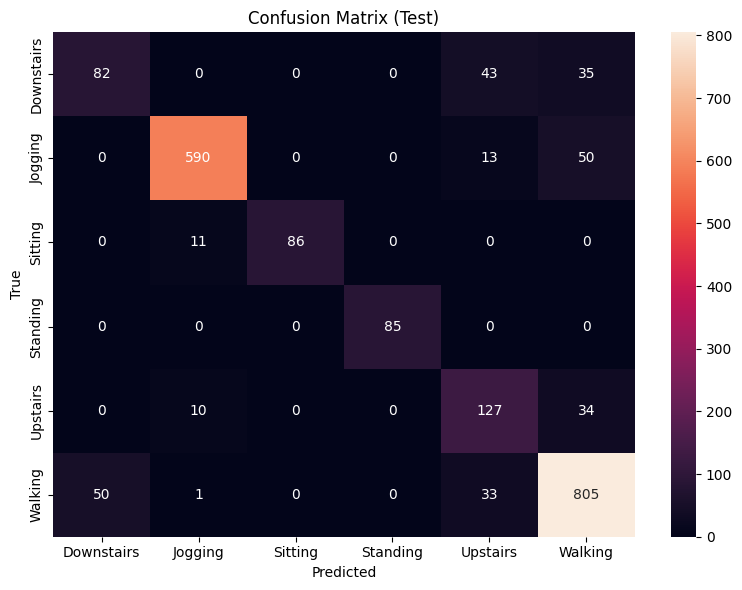

In [35]:
# ----------------------------
# 9) 테스트 평가
# ----------------------------
test_loss, test_acc, y_true, y_pred = evaluate(test_loader)
print(f"[TEST] loss: {test_loss:.4f} | acc: {test_acc:.4f}")

print("\n[Classification Report]")
print(classification_report(y_true, y_pred, target_names=list(le.classes_), digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix (Test)")
plt.tight_layout()
plt.show()

In [36]:
# ----------------------------
# 10) 예측 함수 예시
# ----------------------------
def predict_windows(np_array_3xT: np.ndarray, batch_size=256):
    """
    입력: (N, 3, T) 혹은 (3, T)
    출력: 클래스 인덱스 배열 및 확률
    """
    model.eval()
    if np_array_3xT.ndim == 2:
        np_array_3xT = np_array_3xT[None, ...]
    Xn = transform_with_scaler(np_array_3xT.astype(np.float32), scaler)
    X_tensor = torch.from_numpy(Xn)
    preds_all, probs_all = [], []
    with torch.no_grad():
        for i in range(0, len(X_tensor), batch_size):
            xb = X_tensor[i:i+batch_size].to(DEVICE)
            out = model(xb)
            prob = nn.Softmax(dim=1)(out)
            pred = out.argmax(1).cpu().numpy()
            preds_all.append(pred)
            probs_all.append(prob.cpu().numpy())
    preds_all = np.concatenate(preds_all)
    probs_all = np.concatenate(probs_all)
    return preds_all, probs_all

print("\n라벨 인덱스→이름 매핑:", {i: name for i, name in enumerate(le.classes_)})


라벨 인덱스→이름 매핑: {0: 'Downstairs', 1: 'Jogging', 2: 'Sitting', 3: 'Standing', 4: 'Upstairs', 5: 'Walking'}
